## Cluster Profiling

Statistical analysis and visualization of functional profiles for genes and gene clusters.

> In recently years, high-throughput experimental techniques such as microarray, RNA-Seq and mass spectrometry can detect cellular molecules at systems-level. These kinds of analyses generate huge quantitaties of data, which need to be given a biological interpretation. A commonly used approach is via clustering in the gene dimension for grouping different genes based on their [similarities](https://pubmed.ncbi.nlm.nih.gov/20179076/).

> To search for shared functions among genes, a common way is to incorporate the biological knowledge, such as Gene Ontology (GO) and Kyoto Encyclopedia of Genes and Genomes (KEGG), for identifying predominant biological themes of a collection of genes.

In [1]:
origin <- getwd()

# Load my own function from the library directory
libdir <- "../utils/"
setwd(libdir)
source("ontology_utils.R")
setwd(origin)

# Change directory to workspace (where to store the data).
basedir <- "../"
setwd(basedir)

In [2]:
fig2_save_dir <- "image/Figure.2.GO.KEGG.DO/"
fig3_save_dir <- "image/Figure.3.Protein-protein.interaction/"

In [3]:
# Change the time out interval bu
david <- DAVIDWebService$new()
setTimeOut(david, 50000)

### Supported ontologies/pathways

- Disease Ontology (via [`DOSE`](https://bioconductor.org/packages/release/bioc/html/DOSE.html))
- Gene Ontology (supports many species with GO annotation query online via [AnnotationHub](https://bioconductor.org/packages/AnnotationHub/))
- KEGG Pathway and Module with latest online data (supports more than 4000 species listed in [KEGG Organisms](http://www.genome.jp/kegg/catalog/org_list.html))
- Protein-protein interaction

### mRNA(DEGs)

<div style="border: solid 1.0px #000000; padding: 0 1em;">
  <h4>Index</h4>
  <ul>
    <li><a href="#[DEGs]-Gene-Ontology">Gene Ontology</a>
    <li><a href="#[DEGs]-KEGG-pathways">KEGG pathways</a>
    <li><a href="#[DEGs]-Disease-Ontology">Disease Ontology</a>
    <li><a href="#[DEGs]-Protein-protein-interaction">Protein protein interaction</a>
  </ul>
</div>

In [4]:
mRNA_data_dir <- "data/GEOquery/DEGs/"
DEGs   <- scan(paste(mRNA_data_dir, "1.Microarray.thresholding.310data.txt",       sep=""), what="character")
ALLGs  <- scan(paste(mRNA_data_dir, "0.Download.and.Pre-processing.33342data.txt", sep=""), what="character")

print_var_length(DEGs)
print_var_length(ALLGs)

[1] "The number of DEGs : 310"
[1] "The number of ALLGs : 33363"


[`clusterProfiler`](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html) provides bitr and bitr_kegg for converting ID types. User should provides an annotation package, both `fromType` and `toType` can accept any types that supported. (Supported types are shown using `keytypes` command.)

```R
library(org.Hs.eg.db)
keytypes(org.Hs.eg.db)
```

```R
# `bitr`: Biological Id TranslatoR
# `bitr_kegg`: Converting biological IDs using KEGG API
eg <- bitr(DEGs, fromType="SYMBOL", toType=c("ENTREZID"), OrgDb ="org.Hs.eg.db")
head(eg, 3)
```

#### [DEGs] Gene Ontology

```R
# `groupGO` is designed for gene classification based on GO distribution at a specific level.
ggo <- groupGO(gene=DEGs, OrgDb="org.Hs.eg.db", keyType="SYMBOL", ont="CC", level=2, readable=FALSE)
head(ggo, 3)
barplot(ggo)
```

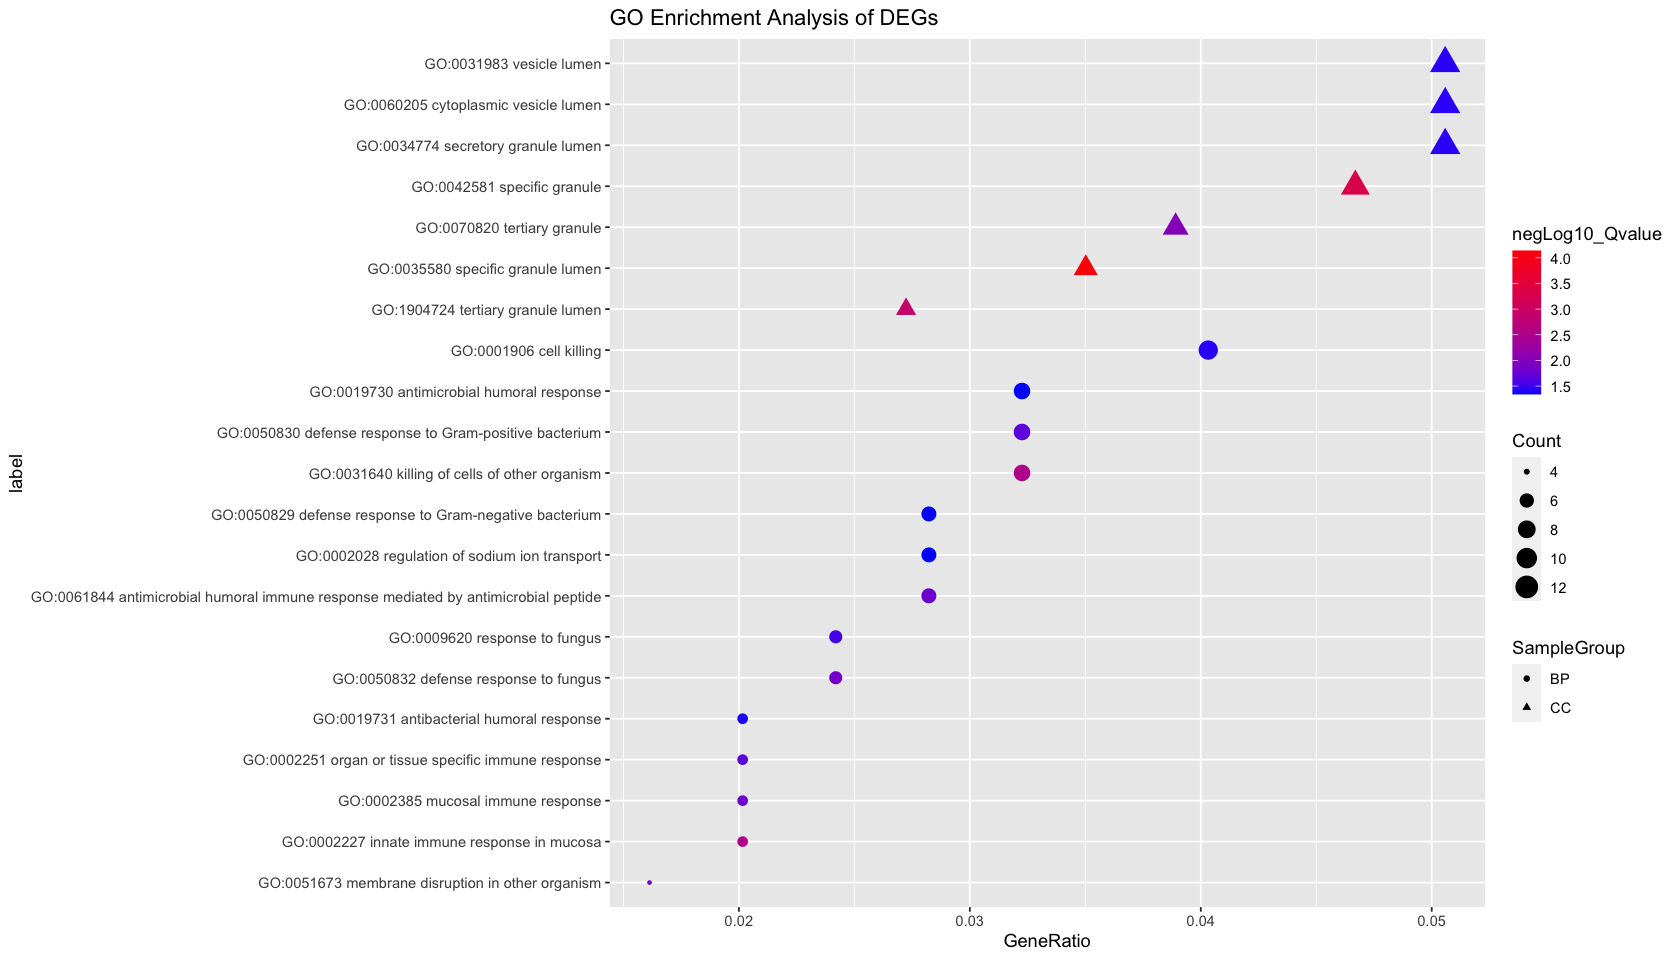

In [5]:
fig2.A.path <- paste(fig2_save_dir, "fig.2.a.GO-for-DEGs.png", sep="")
fig2.A <- enrichGOdotplot(
    gene=DEGs, OrgDb="org.Hs.eg.db", keyType="SYMBOL", pvalueCutoff=0.05, pAdjustMethod="BH",
    universe=ALLGs, qvalueCutoff=0.2, minGSSize=10, maxGSSize=500, readable=FALSE,
    width=14, height=8, title="GO Enrichment Analysis of DEGs"
)
myggsave(fig2.A.path)
fig2.A

#### [DEGs] KEGG pathways

In [6]:
ENTREZ_DEG_IDs  <- geneSYMBOL2EGID(gene_symbol=DEGs)
ENTREZ_ALLG_IDs <- geneSYMBOL2EGID(gene_symbol=ALLGs)

print_var_length(ENTREZ_DEG_IDs)
print_var_length(ENTREZ_ALLG_IDs)

[1] "The number of ENTREZ_DEG_IDs : 310"
[1] "The number of ENTREZ_ALLG_IDs : 33363"


In [7]:
DEG_KEGG_IDs  <- EGID2KEGGID(ENTREZ_GENE_IDs=ENTREZ_DEG_IDs,  expand=TRUE)
ALLG_KEGG_IDs <- EGID2KEGGID(ENTREZ_GENE_IDs=ENTREZ_ALLG_IDs, expand=TRUE)

print_var_length(DEG_KEGG_IDs)
print_var_length(ALLG_KEGG_IDs)

[1] "The number of DEG_KEGG_IDs : 118"
[1] "The number of ALLG_KEGG_IDs : 229"


In [8]:
df.KEGG.DO <- data.frame()

In [9]:
mRNA_kegg <- enrichKEGG(
    gene=DEG_KEGG_IDs, organism="hsa", keyType="kegg", 
    pvalueCutoff=0.05, pAdjustMethod="BH",
    # universe=ALLG_KEGG_IDs,
    minGSSize=10, maxGSSize=500, qvalueCutoff=0.2,
    use_internal_data=FALSE
)
df.mRNA_kegg <- as.data.frame(mRNA_kegg)
if (nrow(df.mRNA_kegg)>0){
  df.mRNA_kegg$SampleGroup <- "KEGG"
  df.KEGG.DO <- rbind(df.KEGG.DO, df.mRNA_kegg)
}

Reading KEGG annotation online:


Reading KEGG annotation online:




#### [DEGs] Disease Ontology

In [10]:
mRNA_david <- enrichDAVID(
    gene=ENTREZ_DEG_IDs , idType="ENTREZ_GENE_ID", 
    pvalueCutoff=0.05, pAdjustMethod="BH",
    # universe=ENTREZ_ALLG_IDs, 
    minGSSize=10, maxGSSize=500, qvalueCutoff=0.2,
    annotation="GOTERM_BP_FAT", species="hsa", 
    david.user="Iwasaki-shuto0703@g.ecc.u-tokyo.ac.jp"
)
df.mRNA_david <- as.data.frame(mRNA_david)
if (nrow(df.mRNA_david)>0){
  df.mRNA_david$SampleGroup <- "Disease Ontology"
  df.KEGG.DO <- rbind(df.KEGG.DO, df.mRNA_david)
}

In [11]:
df.KEGG.DO <- fraction2float(df=df.KEGG.DO, colname="GeneRatio")
df.KEGG.DO$negLog10_Qvalue <- -log10(df.KEGG.DO$qvalue)
df.KEGG.DO$label <- df.KEGG.DO$Description
df.KEGG.DO$label <- factor(df.KEGG.DO$label, levels=df.KEGG.DO$label[order(df.KEGG.DO$SampleGroup, df.KEGG.DO$GeneRatio)])

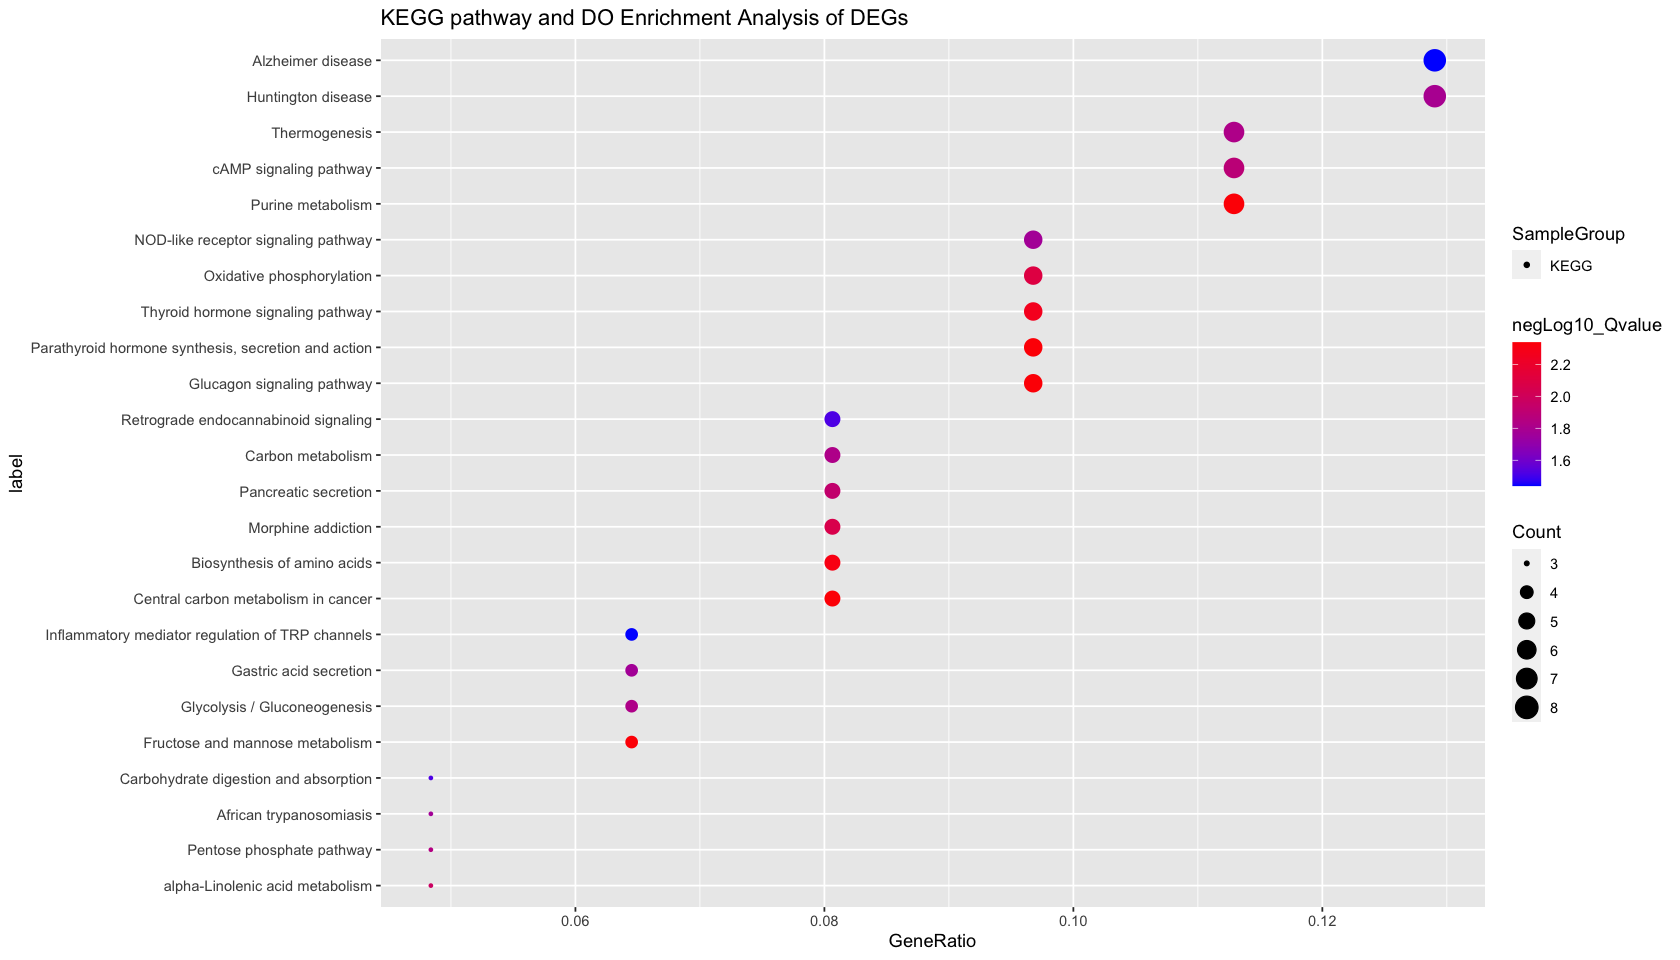

In [12]:
fig2.B.path <- paste(fig2_save_dir, "fig.2.b.KEGG-DO-for-DEGs.png", sep="")
fig2.B <- ggplot() +
geom_point(data=df.KEGG.DO, mapping=aes(x=GeneRatio, y=label, shape=SampleGroup, color=negLog10_Qvalue, size=Count)) +
ggtitle(label="KEGG pathway and DO Enrichment Analysis of DEGs", subtitle=waiver()) +
scale_colour_gradient(low="blue", high="red")
myggsave(fig2.B.path)
fig2.B

#### [DEGs] Protein-protein interaction (PPI)

> Information on protein experimental interactions and prediction was obtained using the [STRING database (version 10.5)](https://doi.org/10.1093/nar/gku1003). Coexpression experiments, gene fusion, neighborhoods, text mining and co-occurrence as the prediction methods were performed for these databases. Except for these, we used combinatorial scores to show the interaction of protein pairs. In the current study, **a combined score >0.9 was set as the threshold** to pick up the hub genes in the network after DEGs were mapped to PPIs. We used **degrees to show the role of protein nodes in the network.** Network modules may have a specific biological significance, so it is usually the core of protein network. We **used Cytoscape software package (version 3.61) to detect main clustering modules.** The most notable clustering modules, were identified using the **Molecular Complex Detection (MCODE) app.** Subsequently, to identify the KEGG pathway for DEGs enrichment, we also employed the `clusterProfiler` package in R and set the threshold at **EASE to ≤0.05, count ≥ 2.** The MCODE score was set at **the cutoff value of >6.**

### miRNA(DEMis)

<div style="border: solid 1.0px #000000; padding: 0 1em;">
  <h4>Index</h4>
  <ul>
    <li><a href="#[DEMis]-KEGG-pathways">KEGG pathways</a>
    <li><a href="#[DEMis]-Disease-Ontology">Disease Ontology</a>
  </ul>
</div>

In [13]:
miRNA_data_dir <- "data/GEOquery/DEMis/"
DEMis   <- scan(paste(miRNA_data_dir, "1.Microarray.thresholding.123data.txt",     sep=""), what="character")
ALLMis  <- scan(paste(miRNA_data_dir, "0.Download.and.Pre-processing.862data.txt", sep=""), what="character")

print_var_length(DEMis)
print_var_length(ALLMis)

[1] "The number of DEMis : 123"
[1] "The number of ALLMis : 862"


#### [DEMis] KEGG pathways

In [14]:
DEMis_KEGG_IDs  <- miRBaseID2KEGG(ALLMis)
ALLMis_KEGG_IDs <- miRBaseID2KEGG(ALLMis)

print_var_length(DEMis_KEGG_IDs)
print_var_length(ALLMis_KEGG_IDs)

[1] "The number of DEMis_KEGG_IDs : 0"
[1] "The number of ALLMis_KEGG_IDs : 0"


In [15]:
# fig2.C.path <- paste(fig2_save_dir, "fig.2.c.KEGG-for-DEMis.png", sep="")
# fig2.C <- 
# myggsave(fig2.C.path)
# fig2.C

#### [DEMis] Disease Ontology

In [16]:
DEMis_ENSEMBL_IDs  <- miRBaseID2ENSEMBL(DEMis)
ALLMis_ENSEMBL_IDs <- miRBaseID2ENSEMBL(ALLMis)

print_var_length(DEMis_ENSEMBL_IDs)
print_var_length(ALLMis_ENSEMBL_IDs)

[1] "The number of DEMis_ENSEMBL_IDs : 55"
[1] "The number of ALLMis_ENSEMBL_IDs : 453"


In [17]:
miRNA_david <- enrichDAVID(
    gene=DEMis_ENSEMBL_IDs, idType="ENSEMBL_GENE_ID", 
    pvalueCutoff=0.05, pAdjustMethod="BH",
    # universe=ALLMis_ENSEMBL_IDs, 
    minGSSize=1, maxGSSize=500, qvalueCutoff=0.2,
    annotation="KEGG_PATHWAY", species="hsa", 
    david.user="Iwasaki-shuto0703@g.ecc.u-tokyo.ac.jp"
)

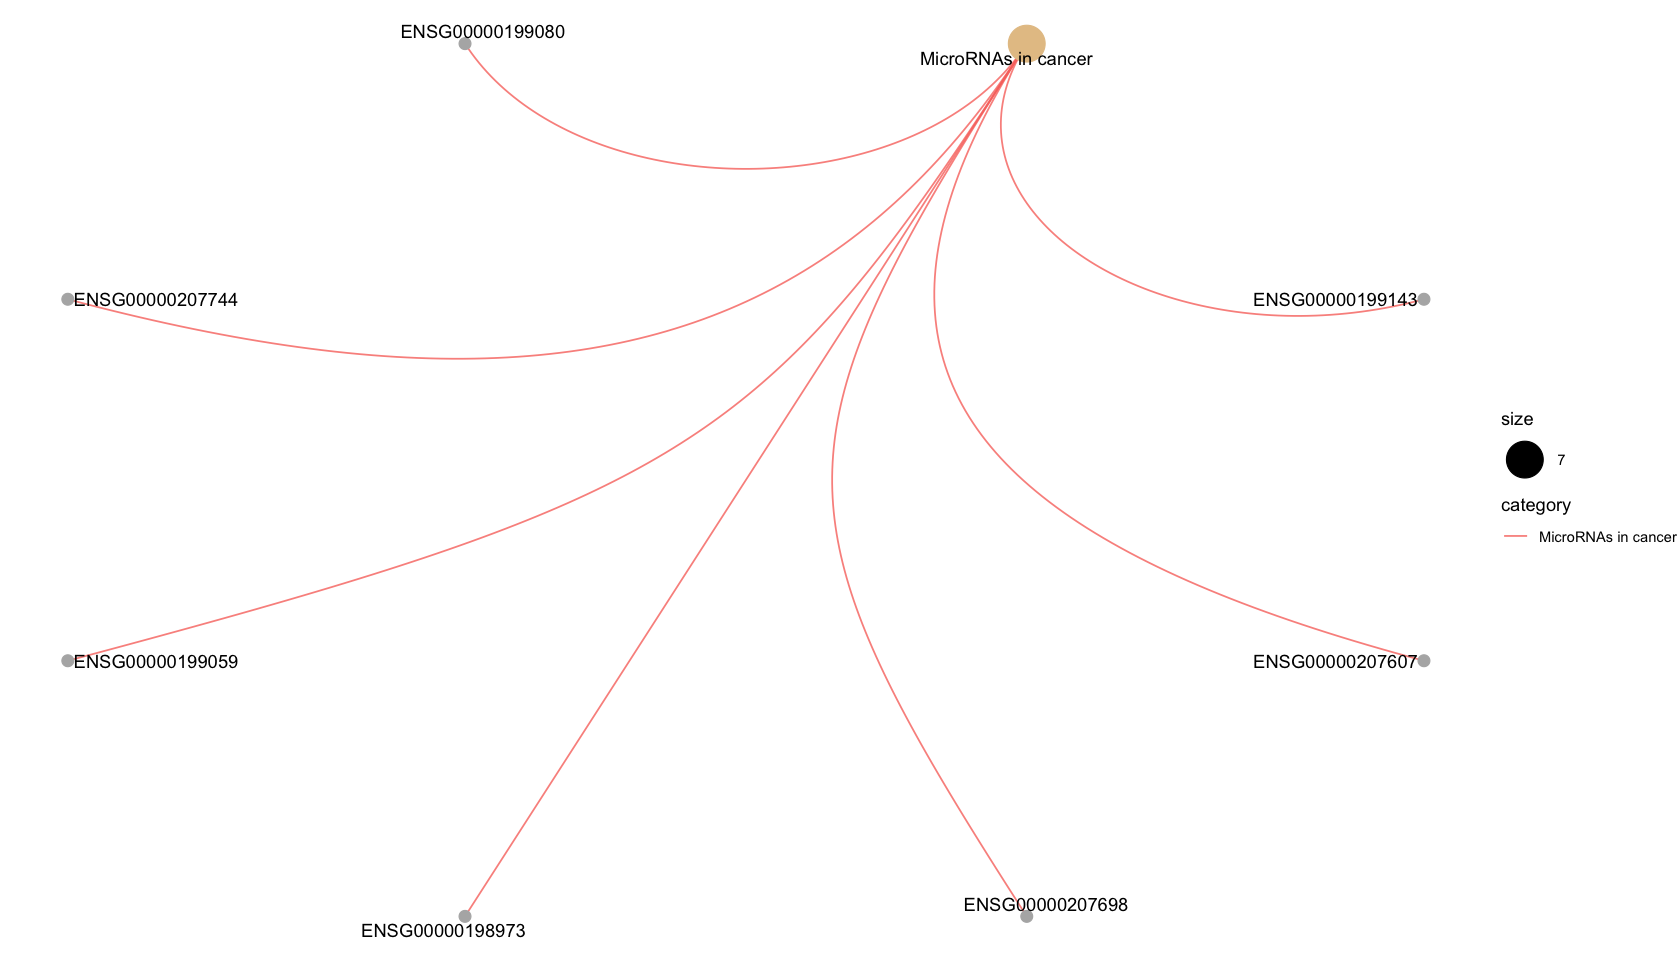

In [18]:
fig2.D.path <- paste(fig2_save_dir, "fig.2.d.DO-for-DEMis.png", sep="")
fig2.D <- cnetplot(miRNA_david, circular=TRUE, colorEdge=TRUE)
myggsave(fig2.D.path)
fig2.D

### Reference

- [GOSemSim: An R Package for Measuring Semantic Similarity Among GO Terms and Gene Products](https://pubmed.ncbi.nlm.nih.gov/20179076/)
- [Statistical analysis and visualization of functional profiles for genes and gene clusters](https://bioc.ism.ac.jp/packages/3.6/bioc/vignettes/clusterProfiler/inst/doc/clusterProfiler.html) 
- package:
   - [`GOplot`](https://cran.r-project.org/web/packages/GOplot/index.html)
   - [`DOSE`](https://bioconductor.org/packages/release/bioc/html/DOSE.html)
   - [`clusterProfiler`](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html)